Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2334 - val_loss: 0.1067
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0632 - val_loss: 0.0098
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9764e-04 - val_loss: 9.1868e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3271e-04 - val_loss: 8.5514e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8500e-04 - val_loss: 8.0641e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

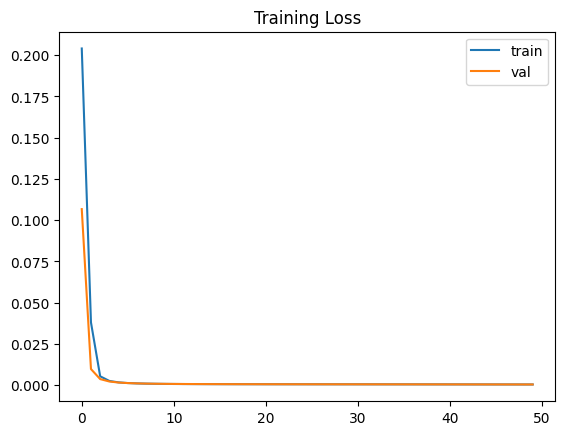

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Anomaly Threshold: 0.000698
Số lượng bất thường phát hiện: 23


In [1]:
# train_autoencoder.ipynb

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Load dữ liệu đã xử lý
df = pd.read_csv('data/processed_log.csv')
messages = df['message'].values

# Vector hóa bằng TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(messages).toarray()

# Chia dữ liệu (vì unsupervised nên train/test từ cùng 1 nguồn)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Xây dựng Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Vẽ biểu đồ loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training Loss")
plt.show()

# Tính lỗi khôi phục để phát hiện bất thường
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Ngưỡng bất thường
threshold = np.percentile(mse, 95)
print(f"Anomaly Threshold: {threshold:.6f}")

# Phân loại bất thường
anomalies = mse > threshold
print(f"Số lượng bất thường phát hiện: {np.sum(anomalies)}")
